# EDA - Google analytics metrics and SpecialDay

The following notebook performs exploratory data analysis on numerical columns

## Contents

- [Bounce Rates](#bounce)
- [Exit Rates](#exit)
- [Page Value](#pagevalue)
- [Special Day](#specday)
- [Page Values and Bounce Rates](#prod_bounce)
- [Summary](#summary)

In [2]:
import pandas as pd
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import os

%reload_ext autoreload
%autoreload 1

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 100)

display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [3]:
from scipy import stats
from statsmodels.stats import weightstats as stests

from Utils.DataUtils import *
from Utils.VizUtils import *

In [4]:
train_data = pd.read_csv("./train_data.csv")
display(
    train_data.shape,
    train_data.head()
)

(8543, 18)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,11,604.73,0,0.0,63,1276.843158,0.0000,0.006712,0.000000,0.0,Jul,2,2,8,6,New_Visitor,False,True
1,1,59.50,0,0.0,20,646.166667,0.0000,0.025333,0.000000,0.0,Dec,2,2,9,3,Returning_Visitor,False,False
2,4,82.50,0,0.0,16,299.500000,0.0000,0.005556,0.000000,0.0,Dec,1,1,4,2,Returning_Visitor,True,False
3,0,0.00,0,0.0,8,704.166667,0.0125,0.035417,0.000000,0.0,Nov,3,2,1,3,Returning_Visitor,False,False
4,1,153.50,0,0.0,20,1002.847222,0.0000,0.009524,41.134331,0.0,Nov,2,2,4,2,Returning_Visitor,False,False


In [5]:
# Quick helper variable
rev_palette = {True:'cornflowerblue', False:'mistyrose'}

NOTE : Since sample sizes in this data set is fairly large, we can approximate binomial distributions to normal distributions

# Bounce Rates<a id='bounce'></a>

Percentage of people who enter the site and leave without triggering any other requests to the analytics server.

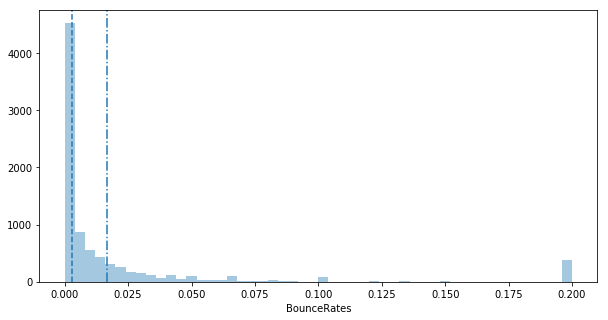

In [6]:
f, ax = plt.subplots(1,1,figsize=(10,5))
g = sns.distplot(train_data["BounceRates"], ax=ax, kde=False)
l = g.axvline(x=np.percentile(train_data["BounceRates"], 50), linestyle="--")
l = g.axvline(x=np.percentile(train_data["BounceRates"], 75), linestyle="-.")

How do bounce rates vary for each Revenue Group?

[(-0.01, 0.1)]

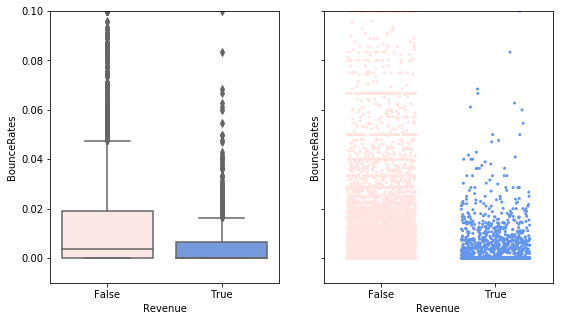

In [7]:
f, ax = plt.subplots(1,2,figsize=(9,5), sharey=True)
g = sns.boxplot(y="BounceRates", x="Revenue", data=train_data, ax=ax[0], orient='vertical', palette=rev_palette)
g = sns.stripplot( y="BounceRates", x="Revenue", data=train_data, ax=ax[1], palette = rev_palette, edgecolor = "white",
                 size = 3, jitter = 0.3, zorder = 0, orient = 'vertical')
g.set(ylim=(-1e-2, 0.1))

[(-0.01, 0.1)]

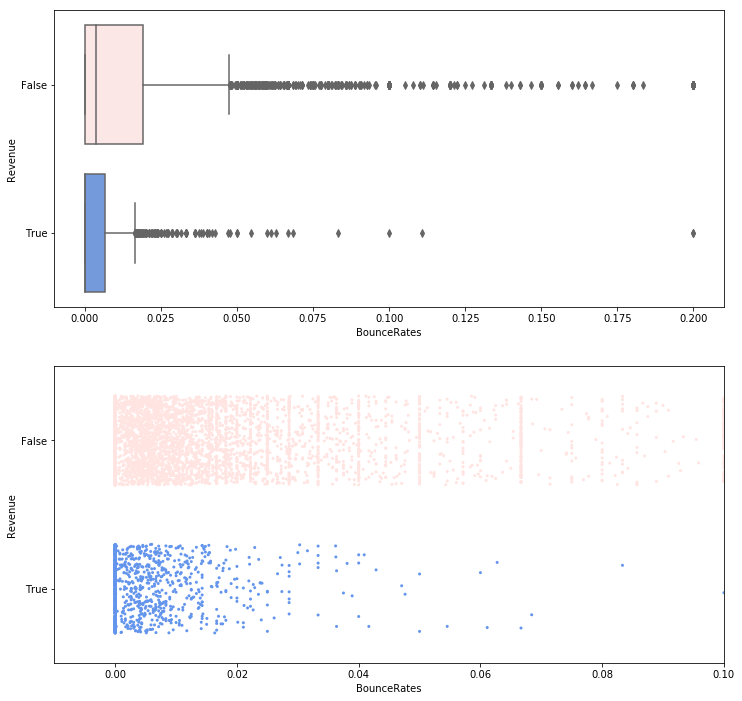

In [8]:
f, ax = plt.subplots(2,1,figsize=(12,12))
g = sns.boxplot(x="BounceRates", y="Revenue", data=train_data, ax=ax[0], orient='horizontal', palette=rev_palette)
g = sns.stripplot( x="BounceRates", y="Revenue", data=train_data, ax=ax[1], palette = rev_palette, edgecolor = "white",
                 size = 3, jitter = 0.3, zorder = 0, orient = 'horizontal')
g.set(xlim=(-1e-2, 0.1))

In [23]:
ztest ,pval = stests.ztest(x1=train_data.query("Revenue==True")['BounceRates'], 
                           x2=train_data.query("Revenue==False")['BounceRates'], 
                           value=0,
                           alternative='two-sided')
print(float(pval))
if pval < 0.05:
    print("We reject null hypothesis")
else:
    print("We fail to reject the null hypothesis")

3.0011332168507174e-40
We reject null hypothesis


Most revenue generating visits happen for pages with low bounce rates

In [9]:
q = "Revenue==True"
train_data.query(q)[["BounceRates"]].describe()

,BounceRates
count,1336.000000
mean,0.005218
std,0.012211
min,0.000000
25%,0.000000
50%,0.000000
75%,0.006642
max,0.200000


In [10]:
th = train_data.query("Revenue==True")[["BounceRates"]].describe().loc["75%"].values[0]
q = "BounceRates<="+str(th)
display(
    train_data["Revenue"].value_counts(),
    100*(train_data["Revenue"].value_counts()/train_data.shape[0]),
    train_data.query(q)["Revenue"].value_counts(),
    100*(train_data.query(q)["Revenue"].value_counts()/train_data.query(q).shape[0])
)
    

False    7207
True     1336
Name: Revenue, dtype: int64

False    84.361466
True     15.638534
Name: Revenue, dtype: float64

False    4128
True     1002
Name: Revenue, dtype: int64

False    80.467836
True     19.532164
Name: Revenue, dtype: float64

##### 20 percent of all visits generate revenue for pages with bounce rates lower than 0.00637

How are distributions of Revenue for pages with less than 75 percentile of the bounce rate distribution?

In [11]:
th = np.percentile(train_data["BounceRates"], 75)
print("BounceRate threshold:", th)
q = "BounceRates<="+str(th)
display(
    train_data.shape[0],
    100*(train_data["Revenue"].value_counts()/train_data.shape[0]),
    train_data.query(q).shape[0],
    100*(train_data.query(q)["Revenue"].value_counts()/train_data.query(q).shape[0])
)

BounceRate threshold: 0.016666667


8543

False    84.361466
True     15.638534
Name: Revenue, dtype: float64

6480

False    80.972222
True     19.027778
Name: Revenue, dtype: float64

How are distributions of Revenue for pages with 0 bounce rate?

In [12]:
q1 = "BounceRates==0"
q2 = "BounceRates!=0"
display(
    100*(train_data.query(q1)["Revenue"].value_counts()/train_data.query(q1).shape[0]),
    100*(train_data.query(q2)["Revenue"].value_counts()/train_data.query(q2).shape[0])
)

False    81.879022
True     18.120978
Name: Revenue, dtype: float64

False    86.431945
True     13.568055
Name: Revenue, dtype: float64

When sites where bounce rates are 0, the percentage of visits that generate revenue are **5% more** than the ones that do not.

In [13]:
q1 = "BounceRates<=0.016"
q2 = "BounceRates>=0.0"
display(
    100*(train_data.query(q1)["Revenue"].value_counts()/train_data.query(q1).shape[0]),
    100*(train_data.query(q2)["Revenue"].value_counts()/train_data.query(q2).shape[0])
)

False    80.84441
True     19.15559
Name: Revenue, dtype: float64

False    84.361466
True     15.638534
Name: Revenue, dtype: float64

Understandably, the visits with really low bounce rates have have a larger tendency to generate revenue. 

In [14]:
ztest ,pval = stests.ztest(x1=train_data.query("Revenue==True")['BounceRates'], 
                           x2=train_data.query("Revenue==False")['BounceRates'], 
                           value=0,
                           alternative='two-sided')
print(float(pval))
if pval < 0.05:
    print("We reject null hypothesis")
else:
    print("We fail to reject the null hypothesis")

3.0011332168507174e-40
We reject null hypothesis


While these rates are clearly different for each group, it may make sense to see how they reach with page visits and time spent on pages

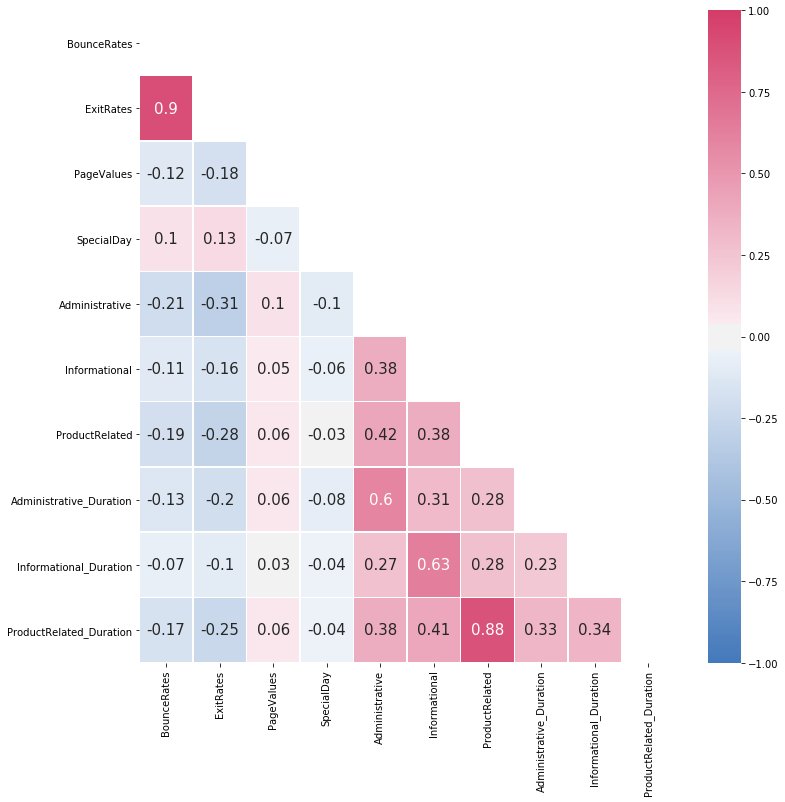

In [15]:
cols = ["BounceRates", "ExitRates", "PageValues", "SpecialDay",
        "Administrative", "Informational", "ProductRelated", 
        "Administrative_Duration", "Informational_Duration", "ProductRelated_Duration"]
f, ax = plt.subplots(1,1,figsize=(12,12))
plot_corr_heatmap(np.round(train_data[cols].corr(), 2), ax=ax, annotate=True)

Do pages with high bounce rates lead to Revenue?

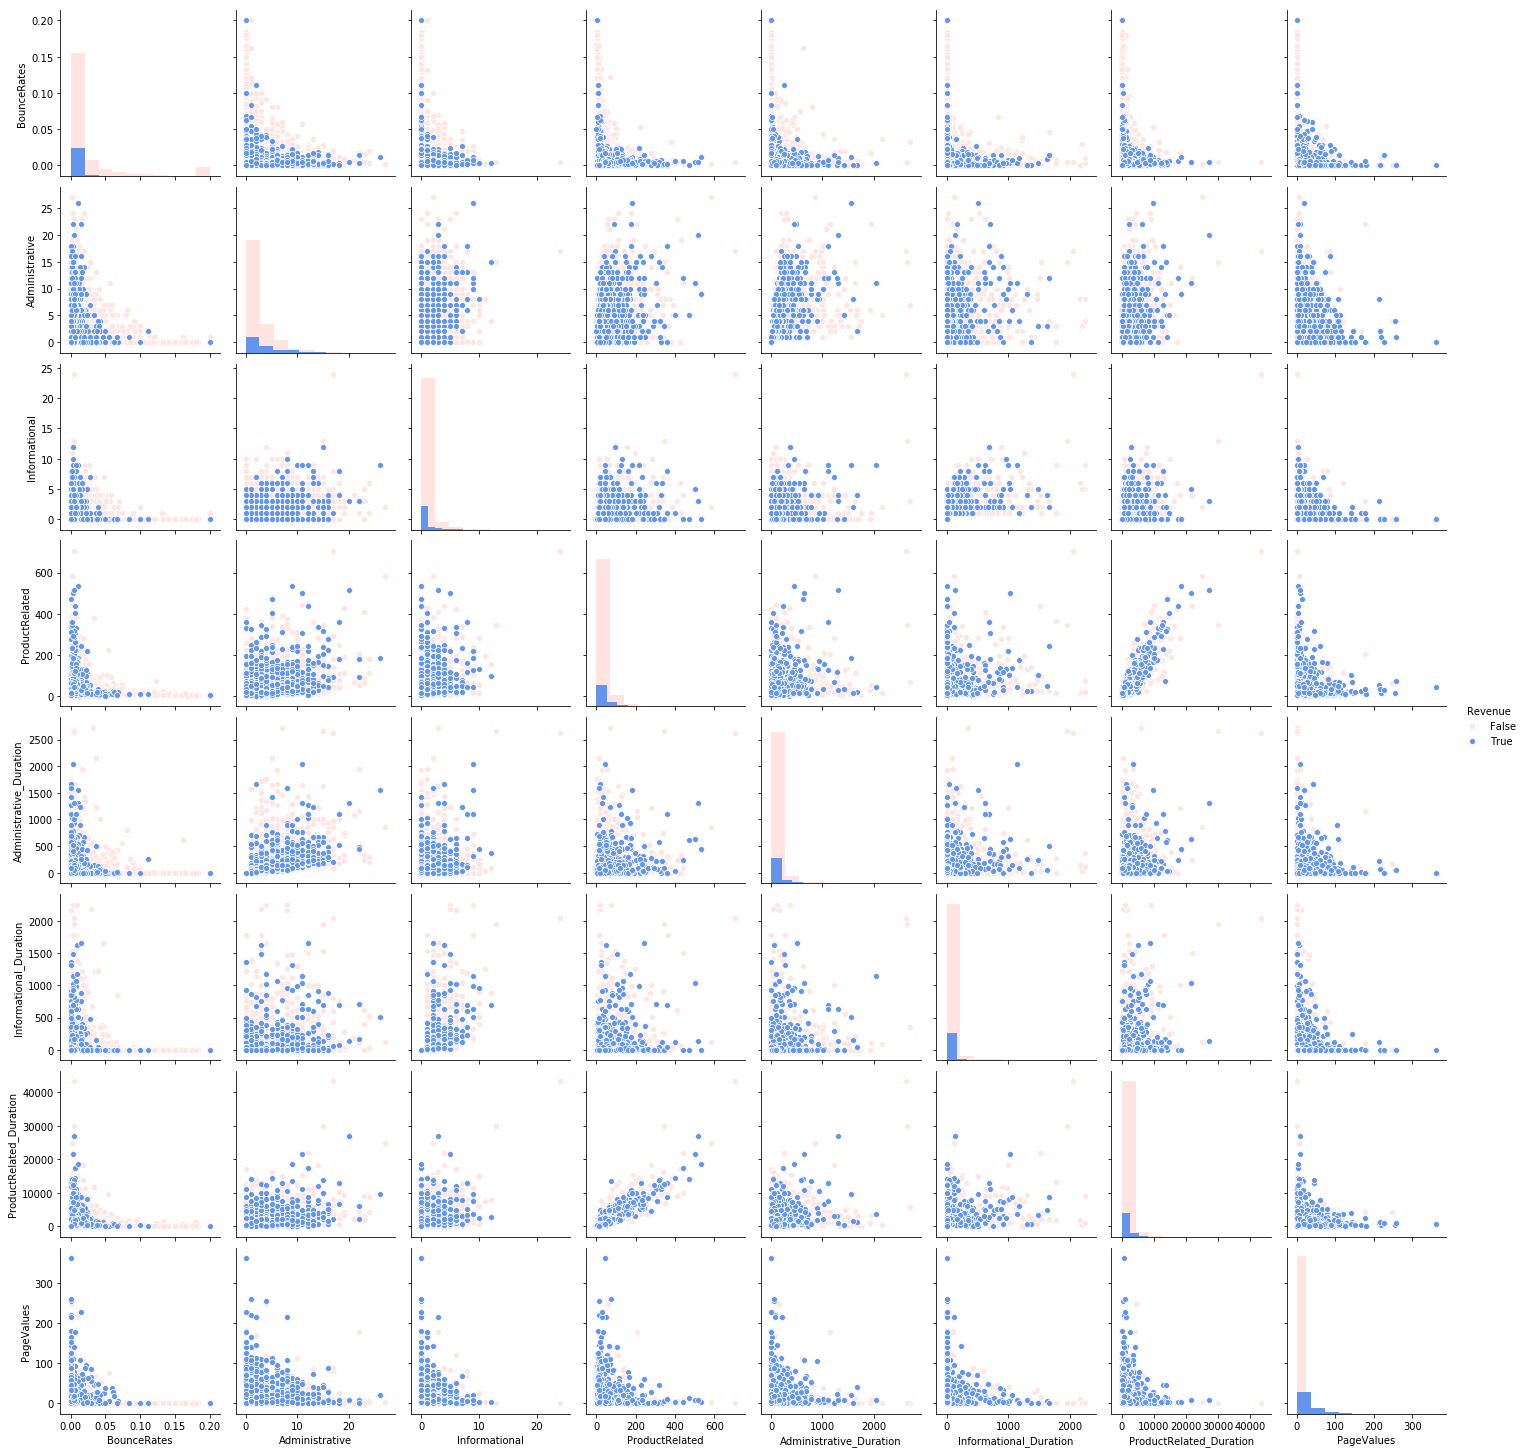

In [16]:
cols = ["BounceRates", 
        "Administrative", "Informational", "ProductRelated", 
        "Administrative_Duration", "Informational_Duration", "ProductRelated_Duration", 
        "Revenue", "PageValues"]
sns.pairplot(train_data[cols], hue='Revenue', palette=rev_palette, diag_kind='hist')

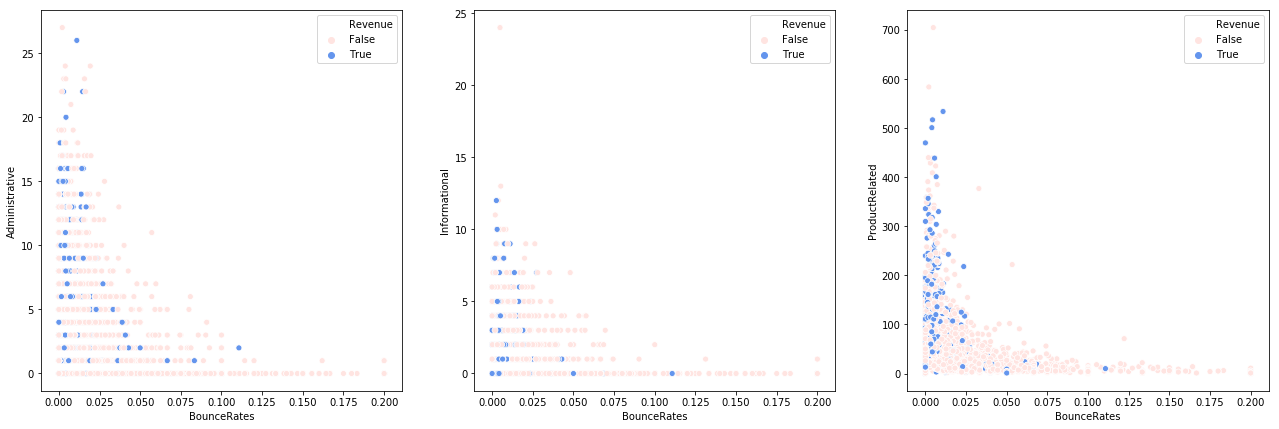

In [17]:
f, ax = plt.subplots(1, 3, figsize=(22,7))
g = sns.scatterplot(x="BounceRates", y="Administrative", hue="Revenue", data=train_data, ax=ax[0], palette=rev_palette)
g = sns.scatterplot(x="BounceRates", y="Informational", hue="Revenue", data=train_data, ax=ax[1], palette=rev_palette)
g = sns.scatterplot(x="BounceRates", y="ProductRelated", hue="Revenue", data=train_data, ax=ax[2], palette=rev_palette)

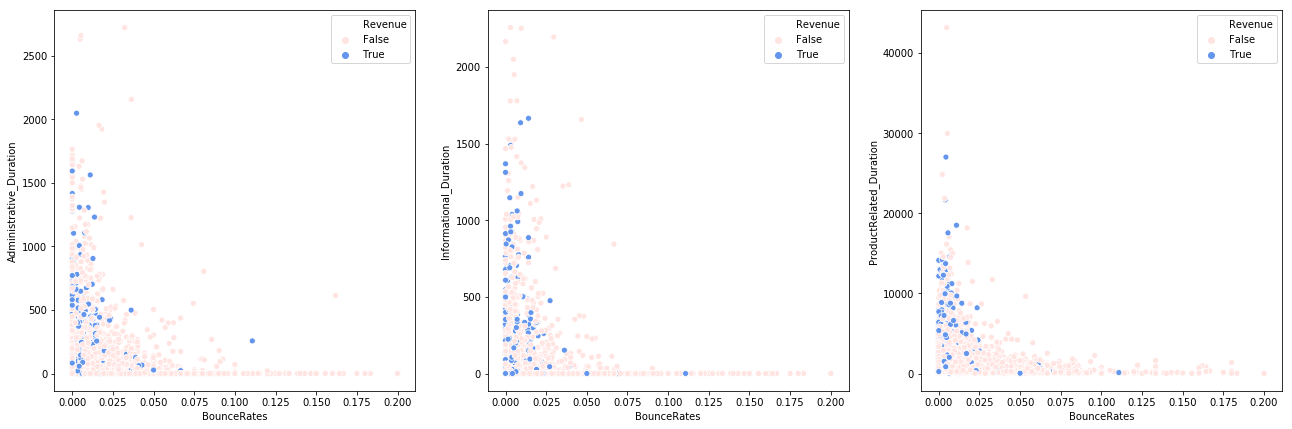

In [18]:
f, ax = plt.subplots(1, 3, figsize=(22,7))
g = sns.scatterplot(x="BounceRates", y="Administrative_Duration", hue="Revenue", data=train_data, ax=ax[0], palette=rev_palette)
g = sns.scatterplot(x="BounceRates", y="Informational_Duration", hue="Revenue", data=train_data, ax=ax[1], palette=rev_palette)
g = sns.scatterplot(x="BounceRates", y="ProductRelated_Duration", hue="Revenue", data=train_data, ax=ax[2],palette=rev_palette)

------------

#  Exit Rates<a id='exit'></a>

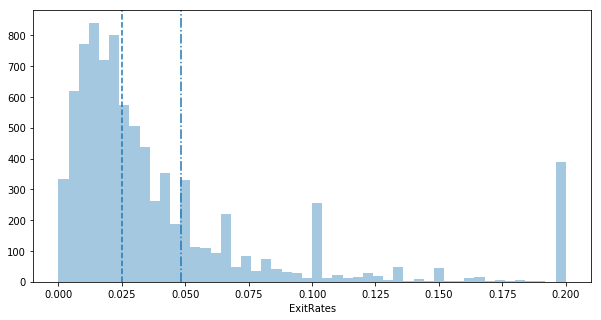

In [20]:
f, ax = plt.subplots(1,1,figsize=(10,5))
g = sns.distplot(train_data["ExitRates"], ax=ax, kde=False)
l = g.axvline(x=np.percentile(train_data["ExitRates"], 50), linestyle="--")
l = g.axvline(x=np.percentile(train_data["ExitRates"], 75), linestyle="-.")

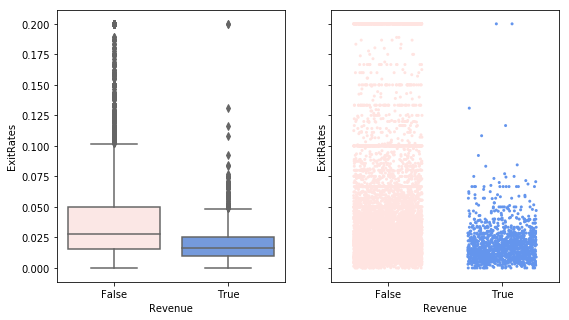

In [19]:
# f, ax = plt.subplots(2,1,figsize=(12,12))
# g = sns.boxplot(x="ExitRates", y="Revenue", data=train_data, ax=ax[0], orient='horizontal', palette=rev_palette)
# g = sns.stripplot( x="ExitRates", y="Revenue", data=train_data, ax=ax[1], palette = rev_palette, edgecolor = "white",
#                  size = 3, jitter = 0.3, zorder = 0, orient = 'horizontal')

f, ax = plt.subplots(1,2,figsize=(9,5), sharey=True)
g = sns.boxplot(y="ExitRates", x="Revenue", data=train_data, ax=ax[0], orient='vertical', palette=rev_palette)
g = sns.stripplot( y="ExitRates", x="Revenue", data=train_data, ax=ax[1], palette = rev_palette, edgecolor = "white",
                 size = 3, jitter = 0.3, zorder = 0, orient = 'vertical')

In [20]:
ztest ,pval = stests.ztest(x1=train_data.query("Revenue==True")['ExitRates'], 
                           x2=train_data.query("Revenue==False")['ExitRates'], 
                           value=0,
                           alternative='two-sided')
print(float(pval))
if pval < 0.05:
    print("We reject null hypothesis")
else:
    print("We fail to reject the null hypothesis")

3.04754409209431e-82
We reject null hypothesis


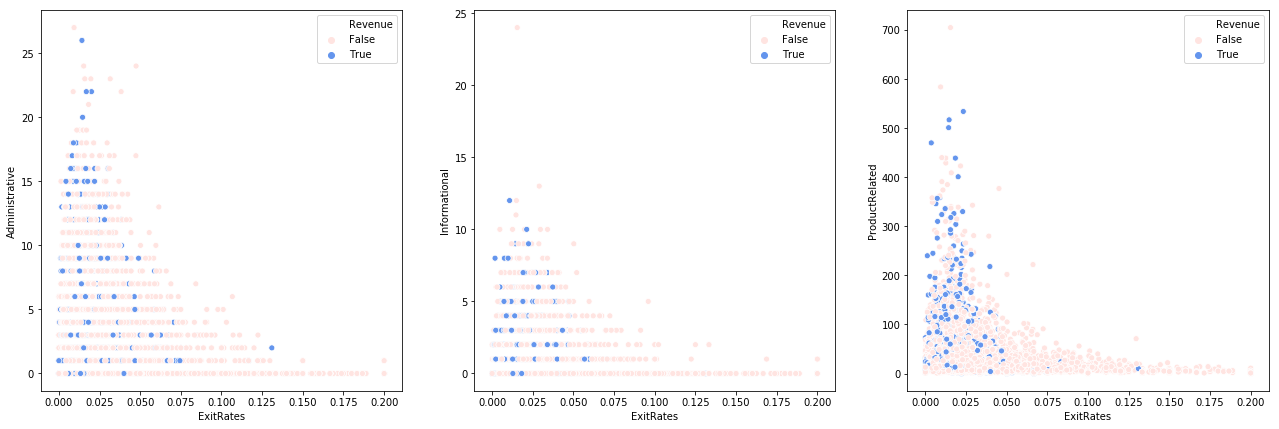

In [21]:
f, ax = plt.subplots(1, 3, figsize=(22,7))
g = sns.scatterplot(x="ExitRates", y="Administrative", hue="Revenue", data=train_data, ax=ax[0],palette=rev_palette)
g = sns.scatterplot(x="ExitRates", y="Informational", hue="Revenue", data=train_data, ax=ax[1], palette=rev_palette)
g = sns.scatterplot(x="ExitRates", y="ProductRelated", hue="Revenue", data=train_data, ax=ax[2], palette=rev_palette)

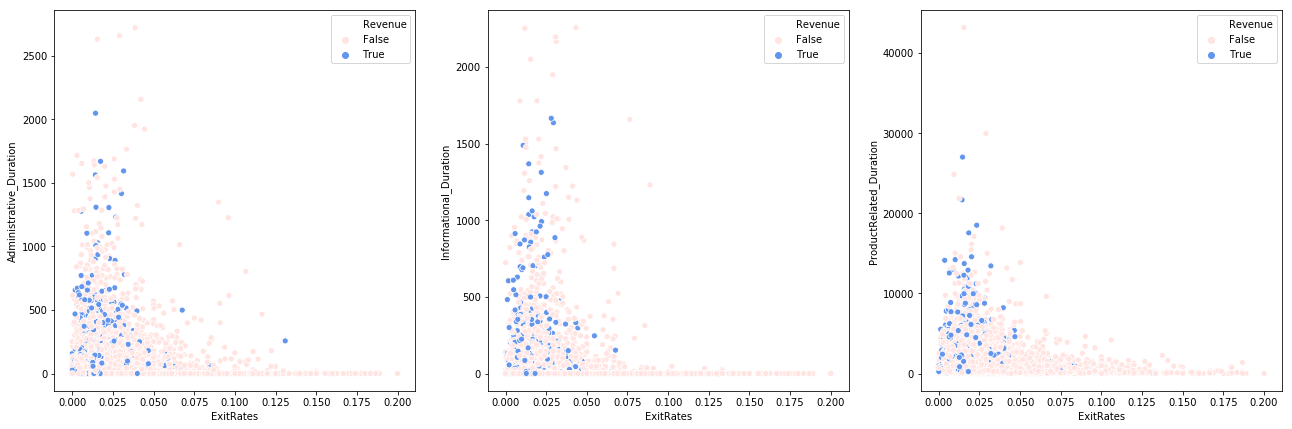

In [22]:
f, ax = plt.subplots(1, 3, figsize=(22,7))
g = sns.scatterplot(x="ExitRates", y="Administrative_Duration", hue="Revenue", data=train_data, ax=ax[0], palette=rev_palette)
g = sns.scatterplot(x="ExitRates", y="Informational_Duration", hue="Revenue", data=train_data, ax=ax[1], palette=rev_palette)
g = sns.scatterplot(x="ExitRates", y="ProductRelated_Duration", hue="Revenue", data=train_data, ax=ax[2], palette=rev_palette)

------------

#  PageValues<a id='pageval'></a>

Average value fo a webpage a user visited before completing an e-commerce transaction

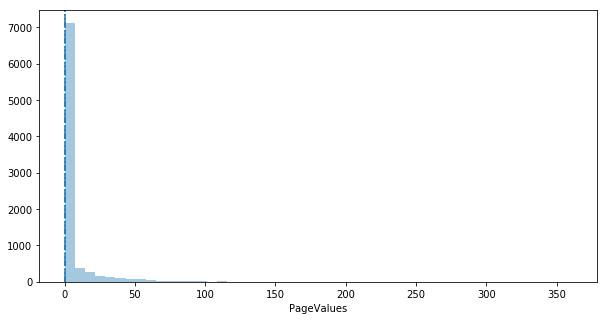

In [23]:
f, ax = plt.subplots(1,1,figsize=(10,5))
g = sns.distplot(train_data["PageValues"], ax=ax, kde=False)
l = g.axvline(x=np.percentile(train_data["PageValues"], 50), linestyle="--")
l = g.axvline(x=np.percentile(train_data["PageValues"], 75), linestyle="-.")

Very skewed distribution

[(-10, 200)]

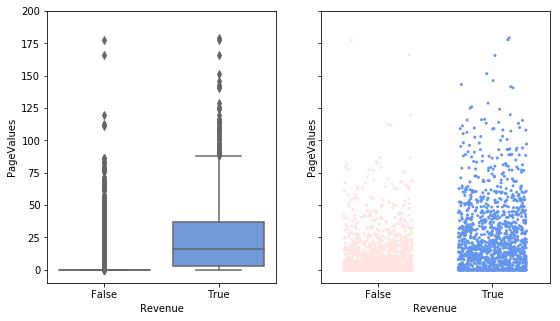

In [24]:
f, ax = plt.subplots(1,2,figsize=(9,5), sharey=True)
g = sns.boxplot(y="PageValues", x="Revenue", data=train_data, ax=ax[0], orient='vertical', palette=rev_palette)
g = sns.stripplot( y="PageValues", x="Revenue", data=train_data, ax=ax[1], palette = rev_palette, edgecolor = "white",
                 size = 3, jitter = 0.3, zorder = 0, orient = 'vertical')
g.set(ylim=(-10,200))

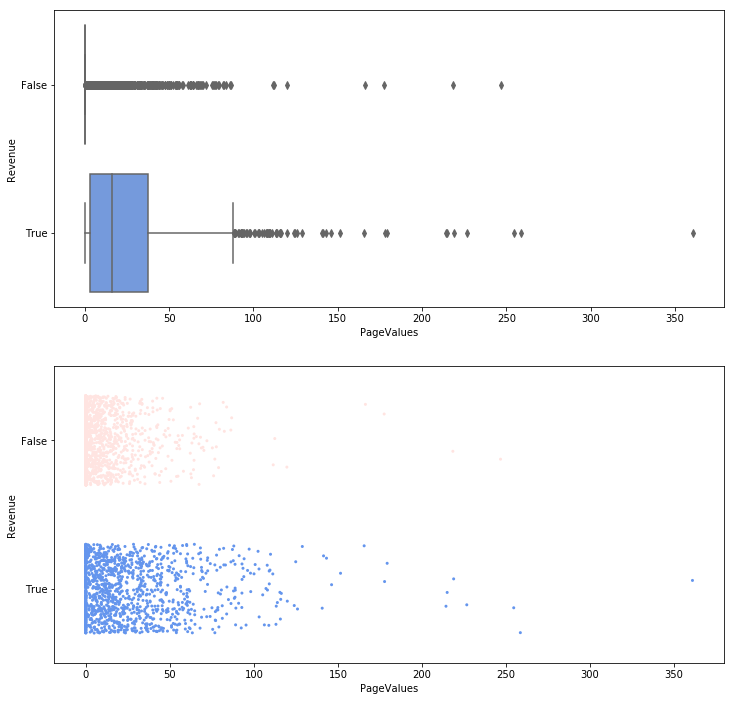

In [25]:
f, ax = plt.subplots(2,1,figsize=(12,12))
g = sns.boxplot(x="PageValues", y="Revenue", data=train_data, ax=ax[0], orient='horizontal', palette=rev_palette)
g = sns.stripplot( x="PageValues", y="Revenue", data=train_data, ax=ax[1], palette = rev_palette, edgecolor = "white",
                 size = 3, jitter = 0.3, zorder = 0, orient ='horizontal')

There is a strong predictive power with page values on whether the user session will result in a purchase.

In [26]:
q = "Revenue==True"
train_data.query(q)[["PageValues"]].describe()

,PageValues
count,1336.000000
mean,26.102024
std,32.511441
min,0.000000
25%,3.174660
50%,16.168067
75%,37.248192
max,360.953384


In [27]:
th = train_data.query("Revenue==True")[["PageValues"]].describe().loc["min"].values[0]
q = "PageValues>"+str(th)
print(q)
display(
    train_data["Revenue"].value_counts(),
    100*(train_data["Revenue"].value_counts()/train_data.shape[0]),
    train_data.query(q)["Revenue"].value_counts(),
    100*(train_data.query(q)["Revenue"].value_counts()/train_data.query(q).shape[0])
)
    

PageValues>0.0


False    7207
True     1336
Name: Revenue, dtype: int64

False    84.361466
True     15.638534
Name: Revenue, dtype: float64

True     1067
False     823
Name: Revenue, dtype: int64

True     56.455026
False    43.544974
Name: Revenue, dtype: float64

In [28]:
q="(PageValues==0)&(Revenue==True)"
train_data.query(q).head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,11,604.730000,0,0.0,63,1276.843158,0.000000,0.006712,0.0,0.0,Jul,2,2,8,6,New_Visitor,False,True
10,1,28.200000,0,0.0,1,0.000000,0.000000,0.050000,0.0,0.0,Sep,1,1,1,5,New_Visitor,False,True
13,7,54.842857,7,475.2,20,393.409524,0.027381,0.033929,0.0,0.0,Jul,2,2,1,4,Returning_Visitor,False,True
65,0,0.000000,2,75.5,109,4008.578283,0.003003,0.018998,0.0,0.0,Nov,2,2,1,2,Returning_Visitor,False,True
84,0,0.000000,0,0.0,22,1664.000000,0.030303,0.032424,0.0,0.0,Nov,1,1,1,2,Returning_Visitor,False,True


##### 43 percent of all visits generate revenue for pages when the pagevalue score is greater than 0

How do statistical tests perform here?

In [29]:
ztest ,pval = stests.ztest(x1=train_data.query("Revenue==True")['PageValues'], 
                           x2=train_data.query("Revenue==False")['PageValues'], 
                           value=0,
                           alternative='two-sided')
print(float(pval))
if pval < 0.05:
    print("We reject null hypothesis")
else:
    print("We fail to reject the null hypothesis")

0.0
We reject null hypothesis


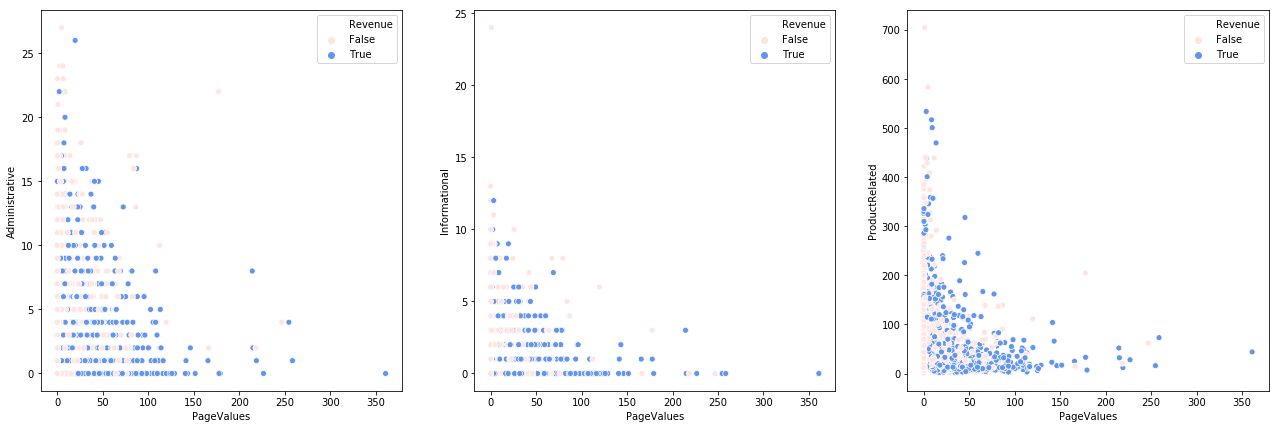

In [30]:
f, ax = plt.subplots(1, 3, figsize=(22,7))
g = sns.scatterplot(x="PageValues", y="Administrative", hue="Revenue", data=train_data, ax=ax[0], palette=rev_palette)
g = sns.scatterplot(x="PageValues", y="Informational", hue="Revenue", data=train_data, ax=ax[1], palette=rev_palette)
g = sns.scatterplot(x="PageValues", y="ProductRelated", hue="Revenue", data=train_data, ax=ax[2], palette=rev_palette)

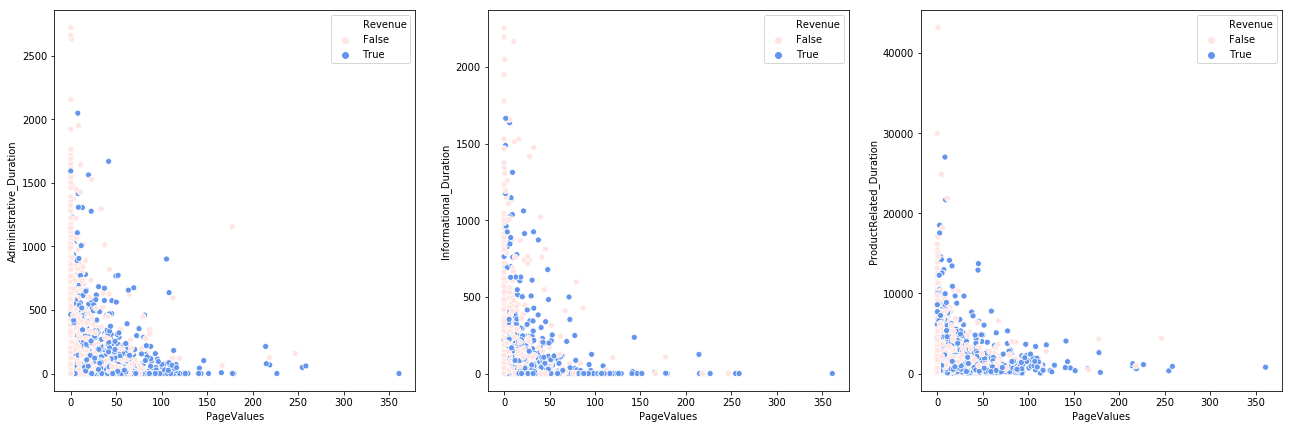

In [31]:
f, ax = plt.subplots(1, 3, figsize=(22,7))
g = sns.scatterplot(x="PageValues", y="Administrative_Duration", hue="Revenue", data=train_data, ax=ax[0], palette=rev_palette)
g = sns.scatterplot(x="PageValues", y="Informational_Duration", hue="Revenue", data=train_data, ax=ax[1], palette=rev_palette)
g = sns.scatterplot(x="PageValues", y="ProductRelated_Duration", hue="Revenue", data=train_data, ax=ax[2], palette=rev_palette)

------------

#  Special Day<a id='specday'></a>

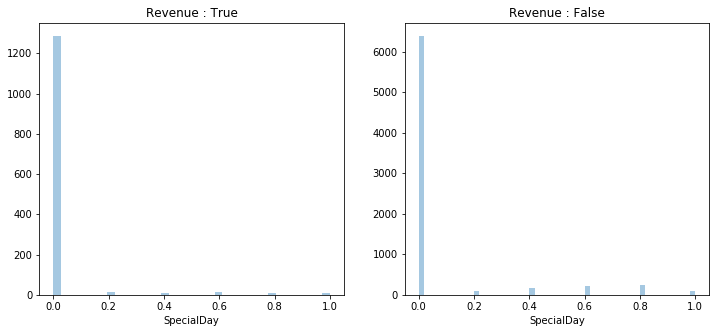

In [32]:
f, ax = plt.subplots(1,2,figsize=(12,5))
g = sns.distplot(a=train_data.query("Revenue==True")["SpecialDay"], ax=ax[0], kde=False)
y = g.set(title="Revenue : True")
g = sns.distplot(a=train_data.query("Revenue==False")["SpecialDay"], ax=ax[1], kde=False)
y = g.set(title="Revenue : False")

In [33]:
ztest ,pval = stests.ztest(x1=train_data.query("Revenue==True")['SpecialDay'], 
                           x2=train_data.query("Revenue==False")['SpecialDay'], 
                           value=0,
                           alternative='two-sided')
print(float(pval))
if pval < 0.05:
    print("We reject null hypothesis")
else:
    print("We fail to reject the null hypothesis")

2.733905986129511e-16
We reject null hypothesis


How do the distribution plots look without Zero?

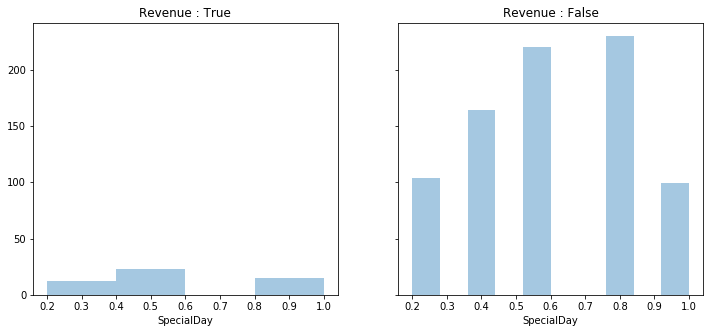

In [34]:
q1 = "(SpecialDay>0)&(Revenue==True)"
q2= "(SpecialDay>0)&(Revenue==False)"
f, ax = plt.subplots(1,2,figsize=(12,5), sharey=True)
g = sns.distplot(a=train_data.query(q1)["SpecialDay"], ax=ax[0], kde=False)
y = g.set(title="Revenue : True")
g = sns.distplot(a=train_data.query(q2)["SpecialDay"], ax=ax[1], kde=False)
y = g.set(title="Revenue : False")

In [35]:
ztest ,pval = stests.ztest(x1=train_data.query(q1)['SpecialDay'], 
                           x2=train_data.query(q2)['SpecialDay'], 
                           value=0,
                           alternative='two-sided')
print(float(pval))
if pval < 0.05:
    print("We reject null hypothesis")
else:
    print("We fail to reject the null hypothesis")

0.13151067257482105
We fail to reject the null hypothesis


This is interesting, When Special Day is not 0, the variable distributions for each group fail statistical significance in difference.

In an algorithm like Logistic regression, it may not have significant effect in this case. (P < 0.05 alpha level)

-------

# PageValues and BounceRates <a id='prod_bounce'></a>

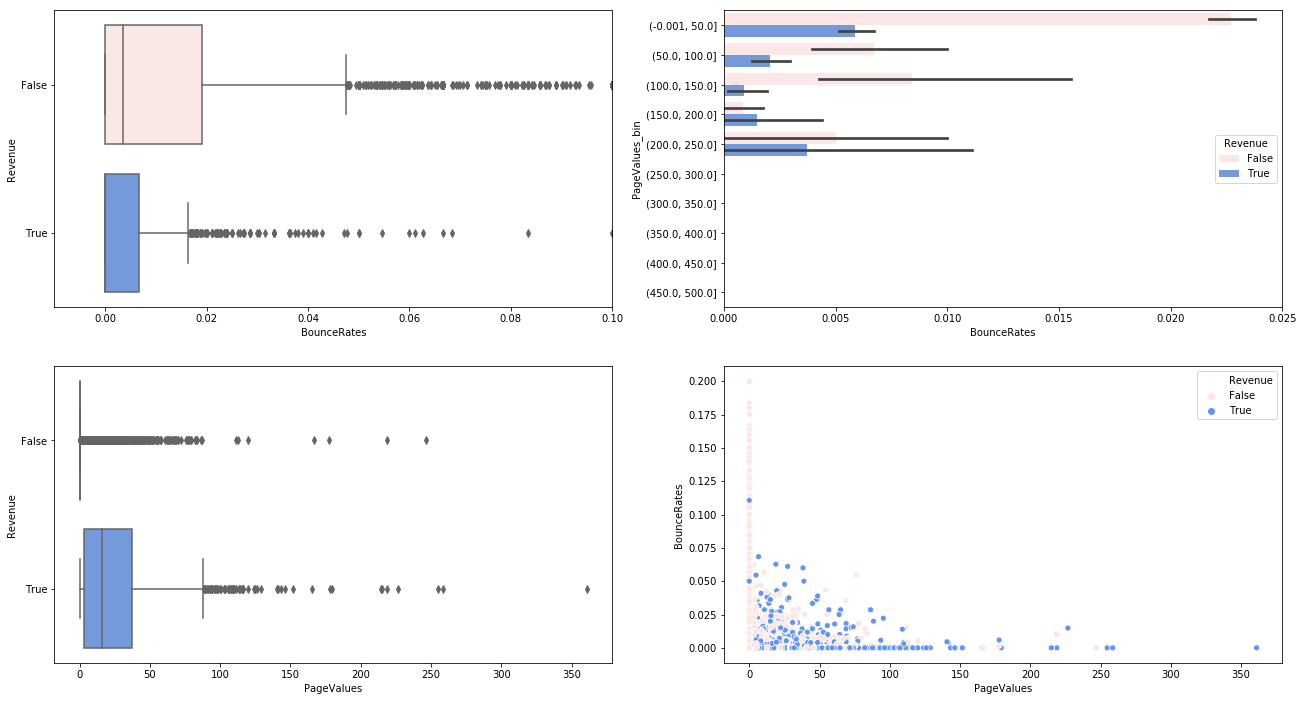

In [21]:
train_data["PageValues_bin"] = pd.cut(train_data["PageValues"], bins=np.linspace(start=0, stop=500, num=11), include_lowest=True)


f, ax = plt.subplots(2,2,figsize=(22,12))
g = sns.boxplot(x="BounceRates", y="Revenue", data=train_data, ax=ax[0][0], orient='horizontal', palette=rev_palette)
g.set(xlim=(-1e-2, 0.1))
g = sns.boxplot(x="PageValues", y="Revenue", data=train_data, ax=ax[1][0], orient='horizontal', palette=rev_palette)
g = sns.scatterplot(x="PageValues", y="BounceRates", data=train_data, ax=ax[1][1], hue="Revenue", palette=rev_palette)
g1 = sns.barplot(y="PageValues_bin", x="BounceRates", data=train_data, ax=ax[0][1], hue="Revenue", palette=rev_palette)


It appears that higher page values have lower bounce rates

What happens if we combine the two variables?

[(-0.1, 0.5)]

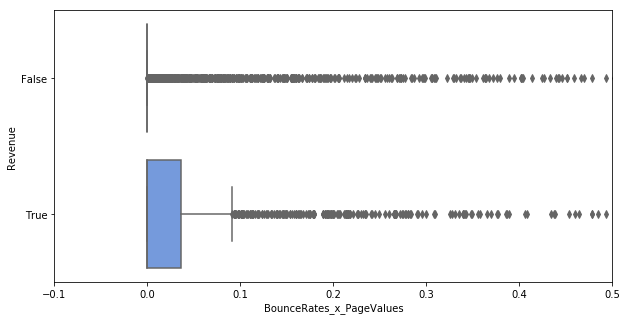

In [22]:
train_data["BounceRates_x_PageValues"] = train_data["BounceRates"] * train_data["PageValues"]
f, ax = plt.subplots(1,1,figsize=(10,5))
g = sns.boxplot(x="BounceRates_x_PageValues", y="Revenue", data=train_data, ax=ax, orient="horizontal", palette=rev_palette)
g.set(xlim=(-0.1,0.5))

In [38]:
ztest ,pval = stests.ztest(x1=train_data.query("Revenue==True")['BounceRates_x_PageValues'], 
                           x2=train_data.query("Revenue==False")['BounceRates_x_PageValues'], 
                           value=0,
                           alternative='two-sided')
print(float(pval))
if pval < 0.05:
    print("We reject null hypothesis")
else:
    print("We fail to reject the null hypothesis")

7.335984255712502e-59
We reject null hypothesis


The combined variable significant as well. 

Regression analysis can provide further insight on this variable's effect.

-------------

# Summary <a id='summary'></a>

- Bounce Rates and Exit values have a high correlation
- Bounce Rates have strong predictive power for target variable
- Product Value have strong predictive power for target variable
- Product Value x Bounce Rates have strong predictive power for target variable

All variables passed statistical significance tests

### Features created - 

- Product value X bounce rates